In [31]:
import collections
import functools
import itertools
import re
import string
import timeit

import matplotlib.pyplot as plt
import nltk
#nltk.download('popular')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import sklearn

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

from utils import *
from topic_utils import *

In [2]:
# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. We can perform our analysis on
- individual tweets
- all tweets for a grouping of the dataframe (e.g. group by userid)
- all tweets in the corpus

In addition,
- hashtags and urls are already in a separate column, as a list of strings.

In general, we want to convert tweet text into tokens for analysis. We will make utility functions which anticipate tokenizing for these levels of analysis.

1. Individual tweets are strings; groups of tweets are lists of strings
1. Preprocessing:
    1. Remove uninformative symbols
    1. Remove 'RT'
    1. Replace urls, hashtags, and @-mentions with generic tokens
    1. Remove stopwords
    1. Lemmatize
1. Apply preprocessing to column of strings OR column of lists of strings
    - Treat column of strings as a single list of strings

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [4]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [5]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

### Pipeline usage

We can test our pipeline for tokenizing the datasets by aggregating all tweets for each user, allowing us to characterize users by the overall contents of their activity.

Aggregation for tweet text can be defined as joining tweet strings into a list of strings:

In [6]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head()

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


In [7]:
def make_tokens(list_of_strings,
                stop_words=[*stopwords.words(),
                          '<-url->', '<-@->', '<-#->', 
                          '...','`',',','-',"'"]):
    """Apply preprocessing and tokenization to a list of strings.
    Usage: 
            output = make_tokens(series_of_strings)

            output = df.apply(make_tokens)
            
    Return:
        A list of lists of tokens for each string.
    """    
    
    t1 = default_timer()

    processed_strings = [preprocess_string(string)
                         for string in list_of_strings]

    tokenized_strings = [tokenize_string(string,
                                         stop_words)
                          for string in processed_strings]
                         
    t2 = default_timer()
    print('elapsed', t2 - t1)
    
    return tokenized_strings

In [8]:
(user_tweets['tweet_text'].head(1)
               .map(make_tokens))

elapsed 0.024903670011553913


userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=    [[america, way, government, treats, people, mu...
Name: tweet_text, dtype: object

In [10]:
user_tokens = (user_tweets['tweet_text']
               .map(make_tokens)
               .map(long_list))

elapsed 0.025895862985635176
elapsed 0.03518855801667087
elapsed 0.13864228600868955
elapsed 0.5205012020014692
elapsed 4.3815092879813164
elapsed 4.141810058004921
elapsed 2.2307123520004097
elapsed 0.8910013900022022
elapsed 3.932361619983567
elapsed 0.3773210700019263
elapsed 0.10099298300337978
elapsed 94.31520478799939
elapsed 0.14582625598995946
elapsed 0.20506099698832259
elapsed 0.09472673598793335
elapsed 0.08533019400783814
elapsed 0.03302997900755145
elapsed 0.013342263002414256
elapsed 0.0016039470210671425
elapsed 0.2174976259993855
elapsed 0.5580283339950256
elapsed 0.21201166600803845
elapsed 0.5009128779929597
elapsed 0.0015246039838530123
elapsed 2.2204905419785064
elapsed 0.020345958007965237
elapsed 1.0027172779955436
elapsed 2.1531271179846954
elapsed 0.032521710003493354
elapsed 0.0008846029813867062
elapsed 0.030910075991414487
elapsed 0.08306157001061365
elapsed 0.0692017340043094
elapsed 0.47423548699589446
elapsed 0.1240116209955886
elapsed 0.01229101899662055


In [11]:
user_tokens

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treats, people, mus...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, و, مقاومت, کمک, نکنه, خاک, ت...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [women, prefer, vote, rapest, pedophile, reall...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     [good, look, tweet, agree, like, #, severe, ha...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     [hapus, zionisme, hapus, penjajahan, israel, l...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      [karl, marx, leader, nothing, dems, asking, cr...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     [sick, tired, lied, amazing, go, vote, better,...
zk4khaX7A3XhX

### Count word frequencies

In [12]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'} sorted by frequency (high to low)
    """
    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [13]:
corpus_freq_dict = word_frequency(long_list(user_tokens))
corpus_freq_dict

{'…': 57903,
 'via': 40982,
 '’': 34702,
 'و': 32049,
 'completa': 25234,
 'trump': 22582,
 '‘': 21534,
 'irán': 18853,
 '“': 18755,
 'eeuu': 18729,
 'yang': 18359,
 '”': 17519,
 '\u200c': 16381,
 '،': 15993,
 'از': 15338,
 'video': 14312,
 'که': 14106,
 'در': 13904,
 'historia': 13126,
 '😂': 12427,
 'israel': 12269,
 'nota': 11551,
 'presidente': 11395,
 'people': 11139,
 'palestina': 9959,
 'gobierno': 9752,
 'silver': 9506,
 'biden': 9431,
 '؟': 9212,
 'را': 8810,
 'us': 8408,
 'این': 8281,
 'siria': 8101,
 'َ': 8006,
 'با': 7964,
 'iraní': 7619,
 'país': 7290,
 'uploaded': 6882,
 'ejército': 6880,
 'mueos': 6699,
 'است': 6268,
 'nuevo': 6135,
 'fuerzas': 5988,
 'added': 5639,
 'ataque': 5634,
 'terroristas': 5628,
 'militar': 5510,
 'playlist': 5423,
 'president': 5318,
 'crisis': 5273,
 'رو': 5235,
 'orang': 5211,
 'amp': 5102,
 'pide': 5067,
 'vote': 5056,
 'xttxkplli': 5019,
 'china': 4987,
 'tras': 4951,
 'acuerdo': 4943,
 'price': 4930,
 'guerra': 4882,
 'mundo': 4760,
 'rusia

In [14]:
top_user = (campaign
           .groupby('userid')
           .size()
           .idxmax())
user_tweets.loc[top_user]

tweet_text    [¡Quedan 3 episodios para el final!\nSerie "El...
Name: 213589457, dtype: object

In [20]:
top_user_tokens = user_tokens.loc[top_user]
top_user_tokens[:20]

['¡',
 'quedan',
 'episodios',
 'final',
 'serie',
 'profeta',
 'josé',
 'días',
 'gmt',
 'repite',
 'nicaragua',
 'país',
 'seguro',
 'centroamérica',
 'competencia',
 'militares',
 'israelíes',
 'matar',
 'palestinos',
 'construcción']

In [21]:
document_freq_dict = word_frequency(top_user_tokens)

## Word cloud

In [22]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
    
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

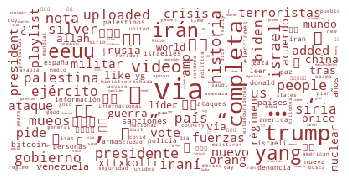

In [23]:
# TODO: render Arabic
fig = visualize(corpus_freq_dict)

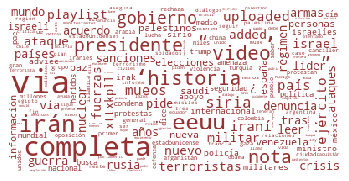

In [24]:
fig = visualize(document_freq_dict)

### Hashtag frequency + word cloud

In [118]:
hashtags = (campaign
               .loc[:]['hashtags']
               .fillna('')
               )
hashtag_list = [el.strip() for el in long_list(hashtags)
               if el != '']

In [119]:
hashtag_freq = word_frequency(hashtag_list)

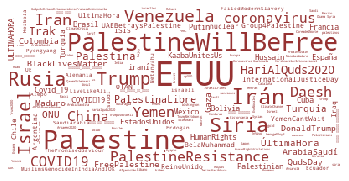

In [102]:
fig = visualize(hashtag_freq)

In [116]:
print('unique hashtags: {}'.format(len(hashtag_freq)))

unique hashtags: 37964


## Vectorizing

Using sklearn's Vectorizers to turn the corpus into a text-term matrix allows us to easily count tokens, and count n-grams as well as single-word tokens.

In [25]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
def tokenize_string(input_string, 
                    stop_words,
                    tokenizer=TweetTokenizer(preserve_case=False,
                                             reduce_len=True,
                                             strip_handles=False),
                    preprocess=False,
                   ):

In [37]:
stop_words = [*stopwords.words(),
              '<-url->', '<-@->', '<-#->', 
              '...','`',',','-',"'",'"']
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, placeholders=True)

In [38]:
vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

documents_list = (user_tweets['tweet_text']
                    .map(long_string)
                   )

In [39]:
documents_list[:5]

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    @VoteMarsha Why Women Prefer to Vote for an ra...
Name: tweet_text, dtype: object

In [52]:
# tokenize + construct the frequency matrix from tokens
matrix = vectorizer.fit_transform(documents_list)

In [53]:
# get token names + frequencies
ngrams = vectorizer.get_feature_names()
ngram_frequencies = matrix.sum(axis=0).tolist()[0]
freq_dict = dict(zip(ngrams, ngram_frequencies))

In [54]:
matrix

<209x2615263 sparse matrix of type '<class 'numpy.int64'>'
	with 3576006 stored elements in Compressed Sparse Row format>

In [55]:
sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:20]

[('…', 57903),
 ('via', 40982),
 ('’', 34702),
 ('و', 32049),
 ('completa', 25234),
 ('trump', 22582),
 ('‘', 21534),
 ('irán', 18854),
 ('“', 18755),
 ('eeuu', 18730),
 ('yang', 18359),
 ('”', 17519),
 ('\u200c', 16381),
 ('،', 15993),
 ('از', 15338),
 ('video', 14312),
 ('که', 14106),
 ('در', 13904),
 ('historia', 13126),
 ('😂', 12427)]

# Topic extraction

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [51]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model which models a corpus as a random mixture of topics and uses the observed words to fit latent variables describing the mixture of topics and the distribution of words in the documents of the corpus.

A corpus consists of $D$ documents ($\sim$vector samples) of $N$ words ($\sim$entry samples) described by $K$ topics ($\sim$classes).

1. For each topic $k \in K$, draw $\beta_{k} \sim \text{Dirichlet}(\eta)$. This represents the probability of a word appearing in topic $k$.


1. For each document $d \in D$: draw the topic proportions $\theta_{d} \sim \text{Dirichlet}(\alpha).$

1. For each word $i$ in document $D$:
    1. Draw the topic assignment $z_{di} \sim \text{Multinomial}(\theta_{d})$
    2. Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$
p(z,\theta,\beta\mid w,\alpha,\eta) = \frac{p(z,\theta,\beta\mid\alpha,\eta)}{p(w\mid\alpha,\eta)}
$$

Variational Bayesian method uses a simpler distribution to approximate the posterior distribution and optimizes parameters in an expectation-minimization procedure. Variational parameters are optimized to maximize the Evidence Lower Bound (ELBO) - maximizing ELBO is equivalent to minimizing the Kullback-Leibler (KL) divergence between the estimate $q$ and the true posterior $p$.

In [56]:
vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             # TODO: preprocessing strings - remove characters??
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

In [57]:
t1 = default_timer()

tf = vectorizer.fit_transform(documents_list)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

elapsed: 44.44758409599308


In [58]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 38.07732723100344


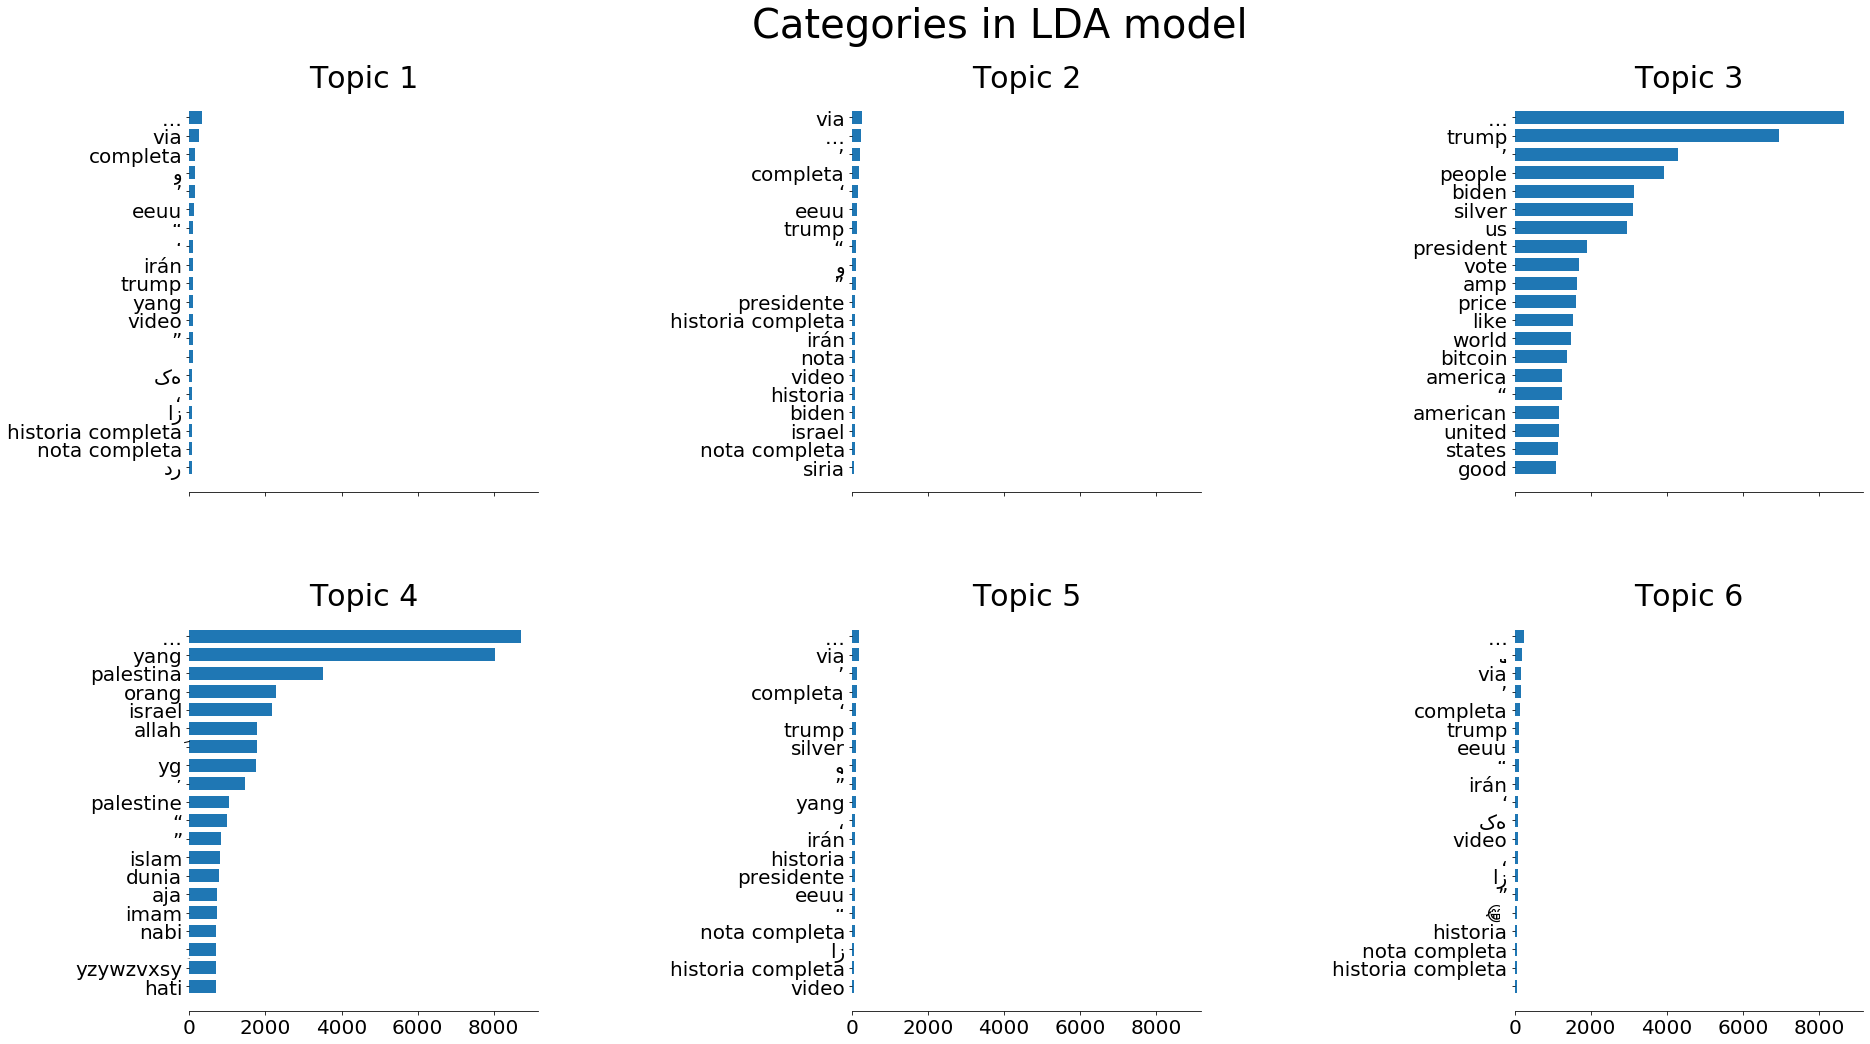

<Figure size 432x288 with 0 Axes>

In [59]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               6,
               'Categories in LDA model')
plt.tight_layout()

Because the "document" level used in this case was per-user tweet token aggregates, we can perhaps consider these topics to be analogous to categories of users, based on their overall tweet set. Considering this campaign was so long, it is likely that the specific topics of tweets changed over time, so in further analysis, we might perform more filtering of the tweets in advance of clustering, for instance isolating tweets from a certain period of time.

In [68]:
"""Variational parameters for topic word distribution. 

Since the complete conditional for topic word distribution is a 
Dirichlet, components_[i, j] can be viewed as pseudocount that 
represents the number of times word j was assigned to topic i. 
It can also be viewed as distribution over the words for each 
topic after normalization: 
model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
"""
lda.components_

array([[  5.8199317 ,   0.61171845,   0.69515121, ...,   0.56729073,
          0.65271266,   0.62898155],
       [  3.35505731,   0.55888298,   0.57502096, ...,   0.5524137 ,
          0.61449798,   0.57568799],
       [116.32148077,   0.61382994,   0.57942962, ...,   0.56023128,
          1.34985417,   1.2177205 ],
       ...,
       [ 36.85818537,   0.88522095,   0.93936501, ...,   0.52680189,
          0.59630821,   0.71874452],
       [  3.28024036,   0.56704533,   0.68108099, ...,   0.47898913,
          0.62998907,   0.56371118],
       [  5.19628844,   0.65865392,   0.67837118, ...,   0.58033403,
          0.5648359 ,   0.63556448]])

### Utility function

N.B. this applies the custom string preprocessing and then also sklearn's preprocessing

In [65]:
def extract_topics(documents,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=[*stopwords.words(),
                                  '<-url->', '<-@->', '<-#->', 
                                  '...','`',',','-',"'",
                                  '.','^',],
                   ):
    
    vectorizer = CountVectorizer(analyzer='word',
                                 strip_accents='ascii',
                                 stop_words=stop_words,
                                 ngram_range=(1,2),
                                 tokenizer=TweetTokenizer(preserve_case=False,
                                           reduce_len=True,
                                           strip_handles=True).tokenize
                                )
    if apply_preprocessing:
        documents_list = (documents
                            .map(long_string)
                            .map(preprocess_string)
                         )
    else: documents_list = documents

    print('vectorizing...')
    t1 = default_timer()
    tf = vectorizer.fit_transform(documents_list)
    
    print('elapsed: {}'.format(default_timer() - t1))
    
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

In [69]:
stop_words = [*stopwords.words(),
              '<-url->', '<-@->', '<-#->', 
              '...','`',',','-',"'",'"']
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, placeholders=True)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

vectorizing...
elapsed: 30.565775814000517
LDA:
n_samples: 2000
n_features: 1000
n_components: 6


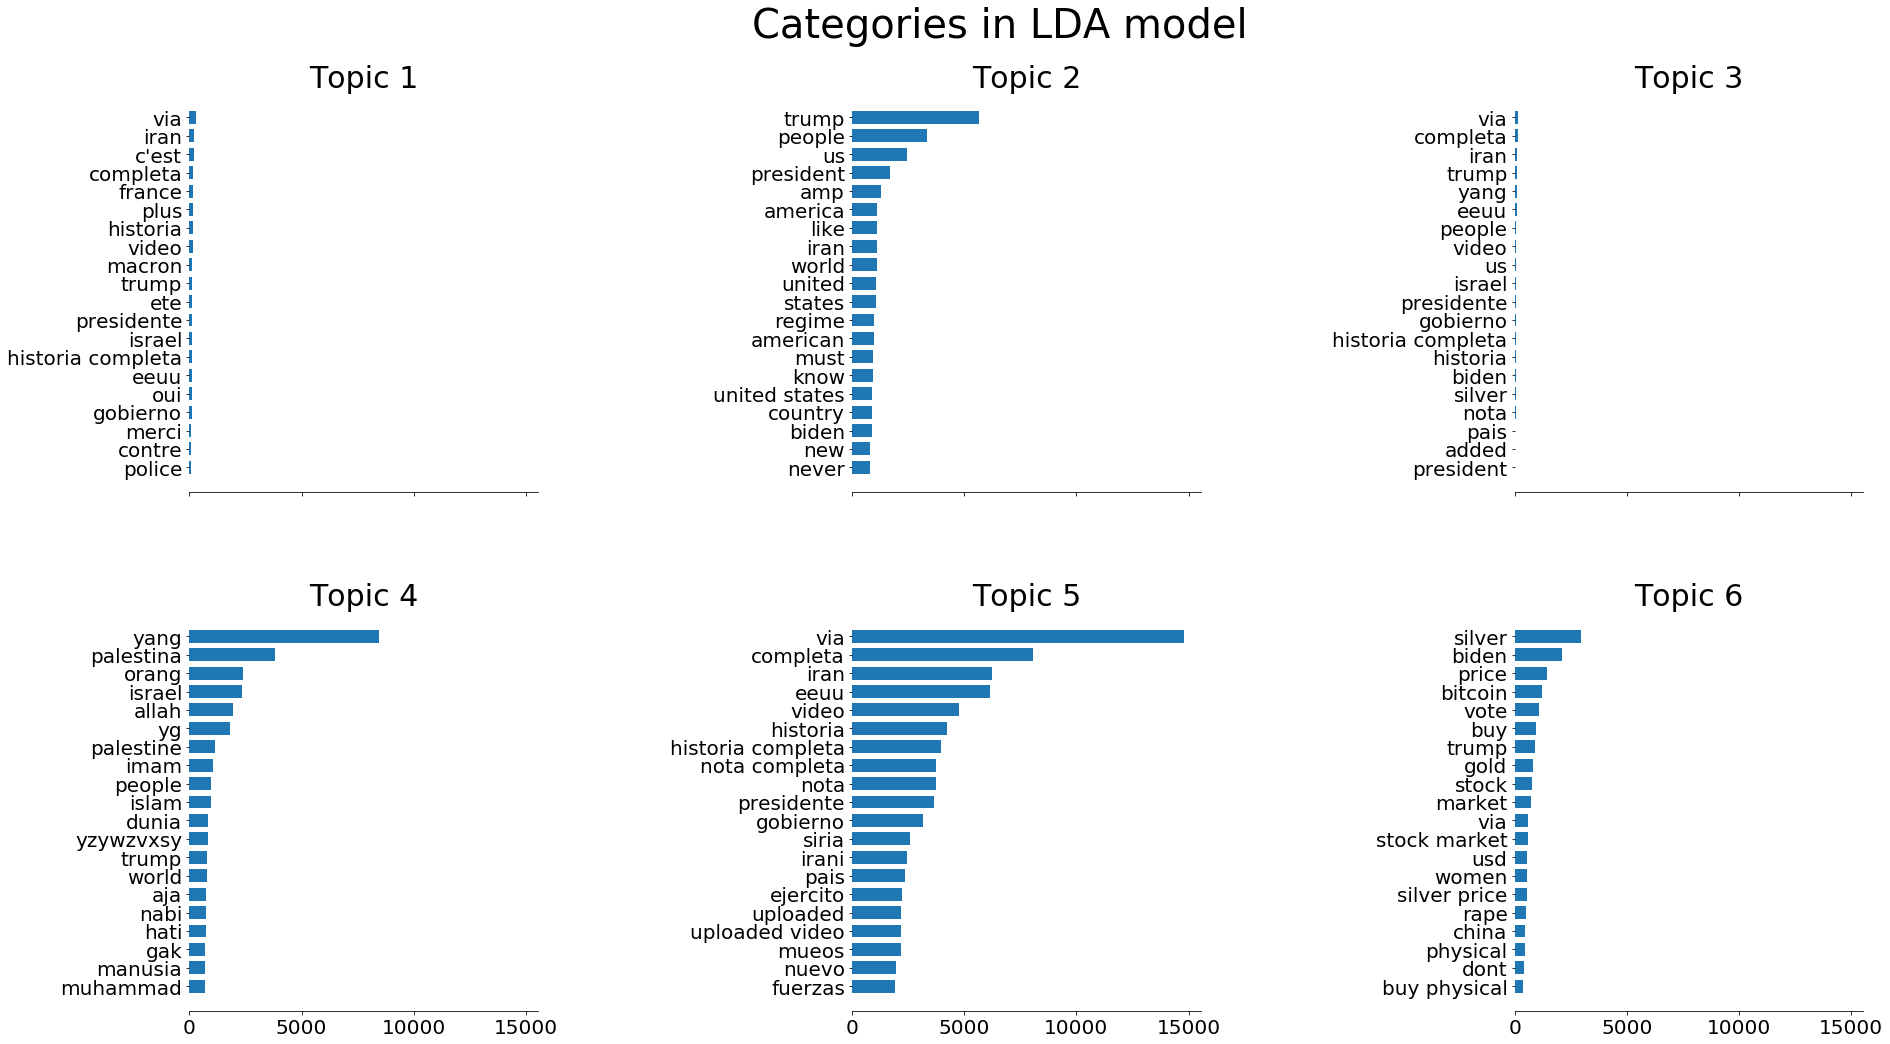

<Figure size 432x288 with 0 Axes>

In [67]:
extract_topics(user_tweets['tweet_text'],
               n_components=6)

### To do:
- mixtures of languages in topics? apply analysis to tweets separated by language? translate things?
- why are special characters not getting removed in custom preprocessing
    - characters removed by sklearn processing, but so is Arabic text and emojis -> review docs